In [ ]:
#LATEST ON COMBINED ORIG/ELA DATASETS

In [1]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import f1_score, accuracy_score
import cv2
import numpy as np
import os, shutil
import time
from PIL import Image
import os
from matplotlib.image import imread

from collections import defaultdict

import torch.nn.functional as F

In [3]:
#pytorch configs
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 3 #how many of training cycles to run?
batch_size = 500 #1000 how many records at one time?
learning_rate = 0.001 #0.001 how fast can you learn? size of the learning step? 0.01 was the best last time
iter_save = 10 #25

# lambda function
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32)
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [5]:
# Define CNN architecture classes
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, padding=1) #changed input to 6 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256) 
        self.prelu = nn.PReLU() 
        self.fc2 = nn.Linear(256, 2) #SINCE BINARY OUTPUT 

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.prelu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Model Functions
#Training the model
def train_model(model, train_loader):
    global loader_map
    results = { loader_name: defaultdict(list) for loader_name in loader_map }
    
    model.train()
    
    running_loss = 0.0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            #labels are the actual values of the images
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            #outputs are the logits of the predicted values of the images 
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i+1)%iter_save == 0:
                #train_f1, train_acc, train_loss = test_model(model, train_loader)
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/iter_save:.4f}")
                running_loss = 0.0

                for loader_name in loader_map:
                    f1, acc, loss = test_model(model, loader_map[loader_name])
                    results[loader_name]['f1'].append(f1)
                    results[loader_name]['acc'].append(acc)
                    results[loader_name]['loss'].append(loss)
    return results

# Testing the model
def test_model(model, test_loader):
    pred = []
    act = []
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader: 
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred_class = torch.max(outputs.data, 1)
            
            pred.append(pred_class)
            act.append(labels)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

        pred = np.concatenate(pred)
        act = np.concatenate(act)
        # f1 scores
        f1 = f1_score(act, pred, average='weighted')
        # accuracies
        acc = accuracy_score(act, pred, normalize=True)
        # loss
        loss = running_loss/len(test_loader.dataset)
    return f1, acc, loss

#plot performance of the models against all datasets in the global data loader map
def plotPerformance(metric, lr, iter):
    loader_name_list = []
    max_len = max([len(results[loader][metric]) for loader in results])
    x_list = np.arange(0, iter*(max_len), iter)
    for loader in results:
        y_list = results[loader][metric]
        loader_name_list.append(loader)
        plt.plot(x_list, y_list)
    plt.legend(loader_name_list, loc="lower right", bbox_to_anchor=(1.0, 1.05))
    plt.xlabel('iterations')
    plt.ylabel(f'{metric} scores')
    plt.xticks(x_list[::20], rotation=90) # Show every second label
    plt.tight_layout()
    #plt.xticks(x_list, rotation=90)
    plt.title(f'{metric} vs iterations for learning rate {lr}')
    plt.show() 
    print (np.hstack((x_list, y_list)))

def convert_files(old_dir_path, new_dir_path):
    if not os.path.isdir(old_dir_path):
        print("is not directory. sad!")
        return
        
    if not os.path.isdir(new_dir_path):
        print("create new directory path first with 0 and 1 sub folders!")
        return
    
    #convert files
    dir = os.fsdecode(old_dir_path)
    for file in os.listdir(dir):
        try:
            src = cv2.imread(os.path.join(dir, file))
            new_file = create_ela(src)
            dst = os.path.join(new_dir_path, file)
            cv2.imwrite(dst, new_file)
        except:
            print(file)
            continue


def save_model(model, rel_file_path):
    #example: "model/CIFAR_real_deepNN.pth")
    torch.save(model, rel_file_path)

def get_model(rel_file_path):
   #Load the saved model
    model = torch.load(rel_file_path, weights_only=False)
    model.eval()
    return model


In [7]:
#Merging the original and ELA datasets

class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

def mergeDataset(set_one, set_two):
    tensor_list = [] #tensors - feature vectors
    y_list = [] #targets 0 or 1
    
    # loop through image paths and their classes and convert into tensors
    for (img_path1, target), (img_path2, _) in zip(set_one.imgs, set_two.imgs):
        image1 = Image.open(img_path1)
        tensor1 = transform(image1)
        image2 = Image.open(img_path2)
        tensor2 = transform(image2)

         #combine tensors from 2 images of 3 X 32 X 32 to 6 X 32 X 32
        combined_tensor = torch.cat((tensor1, tensor2), dim=0)
        tensor_list.append(combined_tensor)
        
        y_list.append(target)

    #Both tensor_list and y_list are a list of tensors. Convert to tensor of tensors.
    X = torch.stack(tensor_list)
    y = torch.tensor(y_list)
    combined_dataset = CustomTensorDataset(X, y)
    
    print(f'{len(X)} records merged.')
    return combined_dataset

### PREPPING DATA FOR TRAINING

In [10]:
bnry_train_dataset = torchvision.datasets.ImageFolder(root='./data/archive/train', transform=transform)
ELA_train_dataset = torchvision.datasets.ImageFolder(root='./data/archive2/train', transform=transform)
combined_dataset = mergeDataset(bnry_train_dataset, ELA_train_dataset)
comb_train_loader = torch.utils.data.DataLoader(dataset=combined_dataset, batch_size=batch_size, shuffle=True)

bnry_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive/test', transform=transform)
ELA_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive2/test', transform=transform)
combined_dataset = mergeDataset(bnry_test_dataset, ELA_test_dataset)
comb_test_loader = torch.utils.data.DataLoader(dataset=combined_dataset, batch_size=batch_size, shuffle=True)

loader_map = {
    "merged_train": comb_train_loader,
    "merged_test": comb_test_loader
}

100000 records merged.
20000 records merged.


In [11]:
bnry_train_dataset.imgs[:5]

[('./data/archive/train/0/1000 (10).jpg', 0),
 ('./data/archive/train/0/1000 (2).jpg', 0),
 ('./data/archive/train/0/1000 (3).jpg', 0),
 ('./data/archive/train/0/1000 (4).jpg', 0),
 ('./data/archive/train/0/1000 (5).jpg', 0)]

In [12]:
#check for records, types, count etc. NOT WORKING
for loader_name, loader in loader_map.items():
    print (loader_name)
    print(type(loader))
    print(loader.dataset.data_tensor.shape)
    print(loader.dataset.target_tensor.shape)
    print(loader.dataset.target_tensor.bincount()) #FAKE and #REAL
    print()

merged_train
<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([100000, 6, 32, 32])
torch.Size([100000])
tensor([50000, 50000])

merged_test
<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([20000, 6, 32, 32])
torch.Size([20000])
tensor([10000, 10000])



### DEFINING MODEL

In [18]:
model = DeepCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### TRAIN THE MODEL

In [15]:
# Select the model
#model = SimpleCNN().to(device)
start_time = time.time()

results = train_model(model, loader_map["merged_train"])
end_time = time.time()
elapsed_time_seconds = end_time - start_time
elapsed_time_hours = elapsed_time_seconds / 3600

print(f"Elapsed time: {elapsed_time_hours} hours")

Epoch [1/3], Step [10/200], Loss: 0.6676
Epoch [1/3], Step [20/200], Loss: 0.6095
Epoch [1/3], Step [30/200], Loss: 0.5519
Epoch [1/3], Step [40/200], Loss: 0.5273
Epoch [1/3], Step [50/200], Loss: 0.5230
Epoch [1/3], Step [60/200], Loss: 0.5079
Epoch [1/3], Step [70/200], Loss: 0.4894
Epoch [1/3], Step [80/200], Loss: 0.4852
Epoch [1/3], Step [90/200], Loss: 0.4850
Epoch [1/3], Step [100/200], Loss: 0.4809
Epoch [1/3], Step [110/200], Loss: 0.4693
Epoch [1/3], Step [120/200], Loss: 0.4795
Epoch [1/3], Step [130/200], Loss: 0.4625
Epoch [1/3], Step [140/200], Loss: 0.4637
Epoch [1/3], Step [150/200], Loss: 0.4533
Epoch [1/3], Step [160/200], Loss: 0.4524
Epoch [1/3], Step [170/200], Loss: 0.4500
Epoch [1/3], Step [180/200], Loss: 0.4510
Epoch [1/3], Step [190/200], Loss: 0.4449
Epoch [1/3], Step [200/200], Loss: 0.4399
Epoch [2/3], Step [10/200], Loss: 0.4362
Epoch [2/3], Step [20/200], Loss: 0.4400
Epoch [2/3], Step [30/200], Loss: 0.4402
Epoch [2/3], Step [40/200], Loss: 0.4428
Epoch

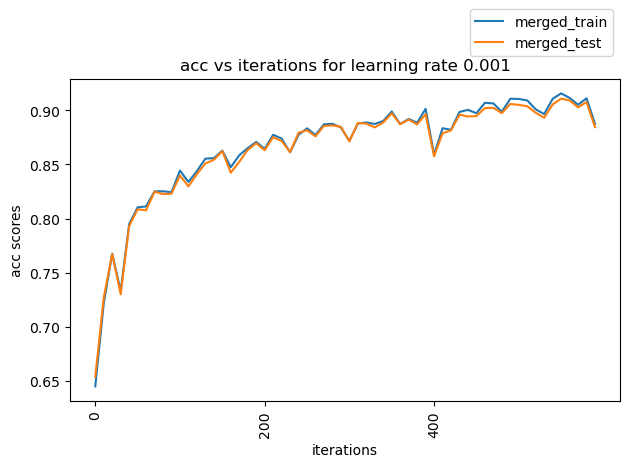

[  0.       10.       20.       30.       40.       50.       60.
  70.       80.       90.      100.      110.      120.      130.
 140.      150.      160.      170.      180.      190.      200.
 210.      220.      230.      240.      250.      260.      270.
 280.      290.      300.      310.      320.      330.      340.
 350.      360.      370.      380.      390.      400.      410.
 420.      430.      440.      450.      460.      470.      480.
 490.      500.      510.      520.      530.      540.      550.
 560.      570.      580.      590.        0.6535    0.7268    0.76715
   0.7299    0.793     0.80855   0.8076    0.82485   0.8226    0.823
   0.83985   0.82975   0.8412    0.85095   0.85435   0.8624    0.8424
   0.85245   0.8635    0.86965   0.86315   0.8753    0.87175   0.8615
   0.87935   0.8817    0.87605   0.8857    0.88615   0.88485   0.87135
   0.8884    0.8878    0.88435   0.8889    0.89735   0.8872    0.89155
   0.8871    0.8965    0.85755   0.8789    0.88155

In [16]:
#COMBINED DATASET Adam optimizer with 20 epochs, 500 batch, and RELU
plotPerformance('acc', learning_rate, iter_save)

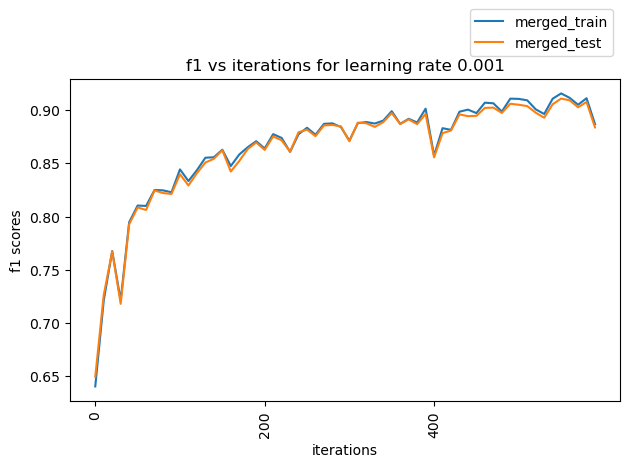

[  0.          10.          20.          30.          40.
  50.          60.          70.          80.          90.
 100.         110.         120.         130.         140.
 150.         160.         170.         180.         190.
 200.         210.         220.         230.         240.
 250.         260.         270.         280.         290.
 300.         310.         320.         330.         340.
 350.         360.         370.         380.         390.
 400.         410.         420.         430.         440.
 450.         460.         470.         480.         490.
 500.         510.         520.         530.         540.
 550.         560.         570.         580.         590.
   0.64928718   0.72616381   0.76713415   0.71788148   0.79265654
   0.8085072    0.80614956   0.82455723   0.82202784   0.82121573
   0.83976707   0.82917236   0.84076611   0.8507429    0.85427325
   0.86237745   0.84234005   0.85219236   0.86346762   0.86961683
   0.86260207   0.8752506    0.87165329 

In [17]:
#COMBINED DATASET Adam optimizer with 20 epochs, 500 batch, and RELU
plotPerformance('f1', learning_rate, iter_save)

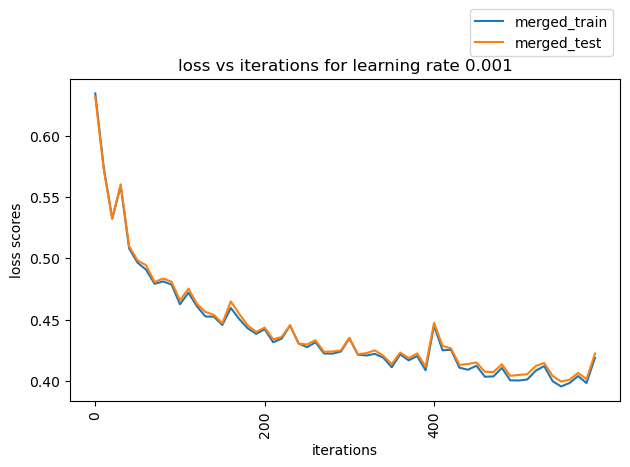

[0.00000000e+00 1.00000000e+01 2.00000000e+01 3.00000000e+01
 4.00000000e+01 5.00000000e+01 6.00000000e+01 7.00000000e+01
 8.00000000e+01 9.00000000e+01 1.00000000e+02 1.10000000e+02
 1.20000000e+02 1.30000000e+02 1.40000000e+02 1.50000000e+02
 1.60000000e+02 1.70000000e+02 1.80000000e+02 1.90000000e+02
 2.00000000e+02 2.10000000e+02 2.20000000e+02 2.30000000e+02
 2.40000000e+02 2.50000000e+02 2.60000000e+02 2.70000000e+02
 2.80000000e+02 2.90000000e+02 3.00000000e+02 3.10000000e+02
 3.20000000e+02 3.30000000e+02 3.40000000e+02 3.50000000e+02
 3.60000000e+02 3.70000000e+02 3.80000000e+02 3.90000000e+02
 4.00000000e+02 4.10000000e+02 4.20000000e+02 4.30000000e+02
 4.40000000e+02 4.50000000e+02 4.60000000e+02 4.70000000e+02
 4.80000000e+02 4.90000000e+02 5.00000000e+02 5.10000000e+02
 5.20000000e+02 5.30000000e+02 5.40000000e+02 5.50000000e+02
 5.60000000e+02 5.70000000e+02 5.80000000e+02 5.90000000e+02
 6.31684566e-01 5.72346304e-01 5.32311893e-01 5.60345165e-01
 5.09699510e-01 4.982233

In [18]:
#COMBINED DATASET Adam optimizer with 20 epochs, 500 batch, and RELU
plotPerformance('loss', learning_rate, iter_save)

In [19]:
##Save the combined model with original + ela data
torch.save(model, "model/BNRYORIG_ELA_deepNN.pth")

In [ ]:
#Load the saved combined model with original + ela data 
#model = torch.load("model/BNRYORIG_ELA_deepNN.pth", weights_only=False)
#model.eval()

## EXTERNAL DATA

In [24]:
#Load the external binary and ELA data and combine them
ext_bnry_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive/ext_test', transform=transform)
ext_ELA_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive2/ext_test', transform=transform)
combined_ext_test_dataset = mergeDataset(ext_bnry_test_dataset, ext_ELA_test_dataset)
comb_ext_test_loader = torch.utils.data.DataLoader(dataset=combined_ext_test_dataset, batch_size=batch_size, shuffle=True)

20000 records merged.


In [36]:
#How many records in external test folder
comb_ext_test_loader.dataset.target_tensor.unique()

tensor([0, 1])

In [42]:
## LOOK AT 1 tesnsor FROM THE combined EXTERNAL TEST DATA
for test_images, test_labels in comb_ext_test_loader:  
    sample_image = test_images[0]    
    sample_label = test_labels[0]

print(sample_image.shape)
print(sample_label)

torch.Size([6, 32, 32])
tensor(1)


In [44]:
#Load the saved binary model on orig data
model = torch.load("model/BNRYORIG_ELA_deepNN.pth", weights_only=False)
model.eval()

f1, acc, loss = test_model(model,comb_ext_test_loader)
f1, acc, loss

(0.33456117899726967, 0.4986, 0.814072248339653)